# Анализ данных землетрясений

## Индивидуальное задание вариант 13

**Задача:** Топ-10 режиссеров по среднему рейтингу

**Источник данных:** https://www.kaggle.com/datasets/carolzhangdc/imdb-5000-movie-dataset


## 1. Загрузка данных из HDFS

Сначала подключимся к Hadoop и загрузим данные из HDFS.


In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import os

# Настройка отображения
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Увеличение размера графиков
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
%pip install hdfs


Note: you may need to restart the kernel to use updated packages.


In [4]:

import os
import pandas as pd
from hdfs import InsecureClient

# Загрузка данных из HDFS
print("Загрузка данных из HDFS...")

# Путь к данным в HDFS
hdfs_path = "/user/hadoop/input/movie.csv"

try:
    # Подключаемся к HDFS
    print("Подключаемся к HDFS через InsecureClient...")
    client = InsecureClient('http://hadoop:9870', user='root')
    
    # Проверяем доступность HDFS
    print("Проверяем доступность HDFS...")
    try:
        # Пробуем получить список файлов в корне
        files = client.list('/')
        print(f"Успешно подключились к HDFS. Файлы в корне: {files}")
    except Exception as e:
        print(f"Ошибка при подключении к HDFS: {e}")
        raise
    
    # Проверяем существование файла movie.csv
    print(f"Проверяем наличие файла {hdfs_path}...")
    if client.status(hdfs_path, strict=False):
        print(f"Файл {hdfs_path} найден в HDFS")
        
        # Читаем файл напрямую из HDFS в DataFrame
        print("Читаем данные из HDFS...")
        with client.read(hdfs_path) as reader:
            df = pd.read_csv(reader)
        
        print(f"Данные успешно загружены из HDFS!")
        print(f"Размер датасета: {df.shape}")
        print("Первые 5 строк:")
        print(df.head())
        print("\nСтолбцы в данных:")
        print(df.columns.tolist())
        
    else:
        print(f"Файл {hdfs_path} не найден в HDFS")
        raise FileNotFoundError(f"Файл {hdfs_path} не найден в HDFS")
        
except Exception as e:
    print(f"Ошибка при работе с HDFS: {e}")
    print("Пробуем найти файл локально...")
    
    # Проверяем наличие файла локально
    local_paths = [
        "/opt/movie.csv",
        "/opt/data/movie.csv", 
        "movie.csv",
        "/user/hadoop/input/movie.csv",
        "/tmp/movie.csv",
        "../movie.csv",
        "./movie.csv",
        "/home/jovyan/movie.csv",
        "/data/movie.csv"
    ]
    
    file_found = False
    for test_path in local_paths:
        if os.path.exists(test_path):
            try:
                df = pd.read_csv(test_path, low_memory=False)
                print(f"Файл найден локально: {test_path}")
                print(f"Размер датасета: {df.shape}")
                print("Первые 5 строк:")
                print(df.head())
                print("\nСтолбцы в данных:")
                print(df.columns.tolist())
                file_found = True
                break
            except Exception as read_error:
                print(f"Ошибка при чтении {test_path}: {read_error}")
                continue
    
    # Если файл не найден ни в HDFS, ни локально, выводим ошибку
    if not file_found:
        print(f"ОШИБКА: Файл movie.csv не найден!")
        print(f"Искали по следующим путям:")
        print(f"  - HDFS: {hdfs_path}")
        for path in local_paths:
            print(f"  - Локально: {path}")
        df = pd.DataFrame()  # Создаем пустой DataFrame

print("\n" + "="*50)
if not df.empty:
    print("ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ!")
else:
    print("ДАННЫЕ НЕ ЗАГРУЖЕНЫ!")
print("="*50)

Загрузка данных из HDFS...
Подключаемся к HDFS через InsecureClient...
Проверяем доступность HDFS...
Ошибка при подключении к HDFS: HTTPConnectionPool(host='hadoop', port=9870): Max retries exceeded with url: /webhdfs/v1/?user.name=root&op=LISTSTATUS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x70c2a081cb60>: Failed to resolve 'hadoop' ([Errno -3] Temporary failure in name resolution)"))
Ошибка при работе с HDFS: HTTPConnectionPool(host='hadoop', port=9870): Max retries exceeded with url: /webhdfs/v1/?user.name=root&op=LISTSTATUS (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x70c2a081cb60>: Failed to resolve 'hadoop' ([Errno -3] Temporary failure in name resolution)"))
Пробуем найти файл локально...
Файл найден локально: movie.csv
Размер датасета: (304683, 28)
Первые 5 строк:
              color       director_name  num_critic_for_reviews  duration  \
0             Color         David Lynch                   350.0     13

In [5]:
# Очистка данных
df_clean = df.copy()
df_clean = df_clean[df_clean['director_name'].notna()]
df_clean = df_clean[df_clean['imdb_score'].notna()]
df_clean = df_clean[df_clean['director_name'] != 'Unknown']

print(f"Количество строк: {len(df_clean)}")
print(f"Уникальные режиссеры: {df_clean['director_name'].nunique()}")

Количество строк: 304518
Уникальные режиссеры: 2357


## 2. Анализ 


In [6]:
# Группировка по режиссеру и вычисление среднего рейтинга
director_ratings = df_clean.groupby('director_name')['imdb_score'].agg(['mean', 'count']).reset_index()
director_ratings.columns = ['Director', 'Mean_Rating', 'Movie_Count']
director_ratings = director_ratings.sort_values('Mean_Rating', ascending=False)

print("Средний рейтинг по режиссерам:")
print(director_ratings.head(10))

# Результат
top_director = director_ratings.iloc[0]
print(f"Режиссер с максимальным средним рейтингом: {top_director['Director']}")
print(f"Средний рейтинг: {top_director['Mean_Rating']:.2f}")
print(f"Количество фильмов: {int(top_director['Movie_Count'])}")

Средний рейтинг по режиссерам:
              Director  Mean_Rating  Movie_Count
1060    John Blanchard          9.5            1
1592  Mitchell Altieri          8.7            1
293          Cary Bell          8.7            1
1971  Sadyk Sher-Niyaz          8.7            1
1578      Mike Mayhall          8.6            1
308    Charles Chaplin          8.6            1
418    Damien Chazelle          8.5            1
1941        Ron Fricke          8.5            1
1799        Raja Menon          8.5            1
1393      Majid Majidi          8.5            1
Режиссер с максимальным средним рейтингом: John Blanchard
Средний рейтинг: 9.50
Количество фильмов: 1


## 3. Визуализация


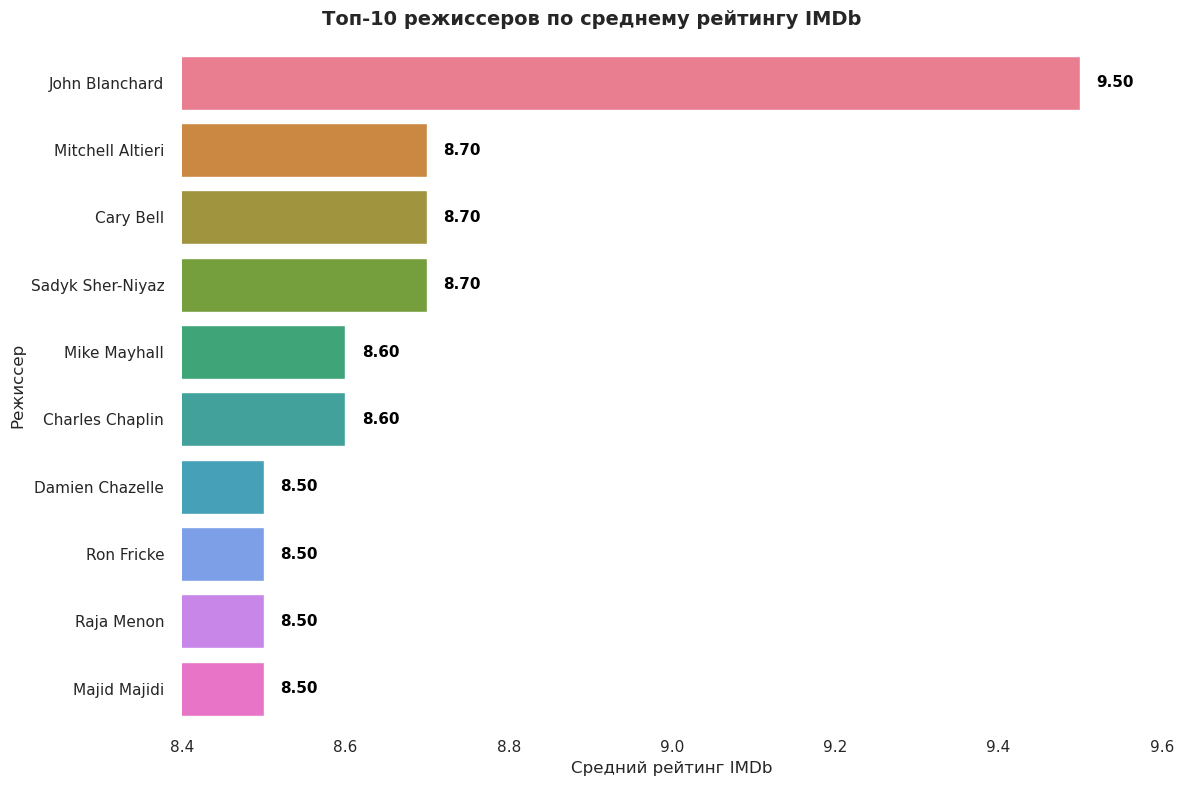

In [7]:
import seaborn as sns

# Настраиваем тему seaborn без сетки
sns.set_theme(style="white")  # Меняем на "white" чтобы убрать сетку полностью

# Берем топ-10 режиссеров
top_10 = director_ratings.head(10)

# Вычисляем диапазон рейтингов для настройки оси X
min_rating = top_10['Mean_Rating'].min()
max_rating = top_10['Mean_Rating'].max()
rating_range = max_rating - min_rating

# Создаем график полностью через seaborn
g = sns.catplot(
    data=top_10,
    kind="bar",
    x="Mean_Rating",
    y="Director",
    hue="Director",
    palette="husl",
    saturation=0.8,
    legend=False,
    height=8,
    aspect=1.5
)

# Добавляем значения рейтингов на столбцы через seaborn
for i, rating in enumerate(top_10['Mean_Rating']):
    g.ax.text(
        rating + 0.02,
        i,
        f'{rating:.2f}',
        va='center',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

# Настраиваем подписи осей и заголовок через seaborn
g.set_axis_labels('Средний рейтинг IMDb', 'Режиссер')
g.fig.suptitle('Топ-10 режиссеров по среднему рейтингу IMDb', 
               y=0.98, fontsize=14, fontweight='bold')

# Растягиваем ось X для лучшей визуализации разницы в рейтингах
g.set(xlim=(min_rating - rating_range * 0.1, max_rating + rating_range * 0.1))

# Отключаем все линии сетки
g.ax.grid(False)  

# Убираем рамки через seaborn
sns.despine(left=True, bottom=True)

# Показываем график
g.fig.tight_layout()